# Wassertein Distance

## Importing libraries

In [6]:
import numpy as np
from scipy import stats
import scipy as sp
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.style.use("science")
import cvxpy as cp
import math
import matplotlib as mpl
from random import shuffle
import pandas as pd

## Distances between distributions

Let
- ($\Omega_{X}$, $F_{X}$, $\mu$) and ($\Omega_{Y}$, $F_{Y}$, $\nu$) be two probability spaces
- $X: \Omega_{X} \rightarrow \mathbb{R}$ and $Y: \Omega_{Y} \rightarrow \mathbb{R}$ two random variables on the same domain D

In [7]:
data = pd.read_csv("../datasets/gaussians.csv")
x = data["x"]
y = data["y"]
n = y.size
assert(n == x.size)

In [8]:
def plot_gaussians(x, y):
    fig, ax = plt.subplots(figsize=(4, 4 ))
    dmax = (y - x).abs()
    z = x
    for k in range(2, 7):
        plt.plot(z + dmax / k, color = "silver")
    for k in range(2, 6):
        plt.plot(z + k*dmax / (k+1), color = "silver")
    ax.plot(range(n), x, color = "darkblue", label = r"$\mu$")
    ax.plot(range(n), y, color = "darkred", label = r"$\nu$")
    ax.set_title("Two gaussian distributions")
    plt.legend()
    plt.show()

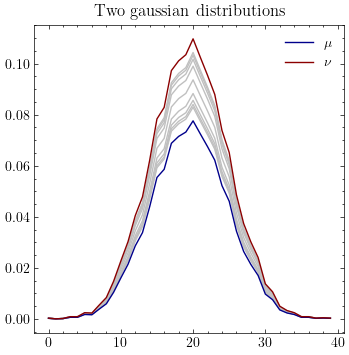

In [9]:
plot_gaussians(x, y)

**Total variation of probabilty measures**

$$
\delta(\mu, \nu) = \sup_{X \times Y} |\mu(x) - \nu(y)| = \dfrac{1}{2} \int_{X \times Y}|\mu(x) - \nu(y)|d\gamma(x,y) : 
\gamma \in \Gamma(\mu, \nu)
$$

In [10]:
.5 * (x - y).abs().sum()

0.20710678118654674

**Hellinger**

$$
\sqrt( \int_{X \times Y} (\sqrt \mu(x) - \sqrt \nu(y))^2)d\gamma(x,y) : \gamma \in \Gamma(\mu,\nu)
$$

In [11]:
np.sqrt( np.sum( (np.sqrt(x) - np.sqrt(y))**2 ) )

0.18920711500272036

**L2**

$$
\int_{X \times Y} (\mu(x) - \nu(y))^2 d\gamma(x,y) : \gamma \in \Gamma(\mu, \nu)
$$

In [12]:
np.sum((x - y)**2)

0.00923557228183476

**$\chi_2$**

$$
\int_{X \times Y} \dfrac{ (\mu(x) - \nu(x))^2 }{\nu(x)} d\gamma(x,y) : \gamma \in \Gamma(\mu, \nu)
$$

In [13]:
np.sum((x - y)**2/(y + 1e-5))

0.12128711429109887

## Wasserstein distance

Let $p \in [0, +\infty[$

The wasserstein distance of order p between $\mu$ and $\nu$ is :

<font color="blue">
$$
\begin{align*}
\mathbf{W}_{p}(\mu, \nu) &= \left( \frac{\inf}{\gamma \in \mathbf{\Gamma}(\mu, \nu)} 
    \int_{\mathbf{X}x\mathbf{Y}} d(x, y)^p  d\gamma(x,y) \right)^{1/p} \\
    &= \left( \dfrac{inf}{\gamma \in \Gamma(\mu, \nu)} \mathbb{E}_{(x,y) \sim \gamma} d(x,y)^p \right)^{1-p}
\end{align*}
$$
</font>

- $\gamma$ is a coupling of $\mu$ and $\nu$
- $\Gamma(\mu, \nu)$ is the set of all couplings of $\mu$ and $\nu$
- $p \in [0, +\infty)$

for $p=1$, the first wasserstein distance is
$$
\mathbf{W}_p = \frac{inf}{\gamma \in \Gamma(\mu, \nu)} \int_{X \times Y} d(x, y)d\gamma(x,y) =
\dfrac{1}{n} \sum_{X \times Y} |x - y|
$$

In [14]:
1/n * np.sum((x - y).abs())

0.010355339059327338

for $p=2$, the second wasserstein distance is
$$
\mathbf{W}_p = (\frac{inf}{\gamma \in \Gamma(\mu, \nu)} \int_{X \times Y} d(x, y)^2d\gamma(x,y))^{1/2} =
(\dfrac{1}{n} \sum_{X \times Y} |x - y|^2)^{1/2}
$$

In [17]:
(1/n * np.sum(np.square(x - y)))**0.5

0.015195042186380037